In [1]:
from os import getcwd
from os.path import abspath, join

import numpy as np
import pickle
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt

from src.models.networks import V1_mnist_RFNet, classical_RFNet
from src.data.load_dataset import load_mnist

In [2]:
data_dir = abspath(join(getcwd(), '../../'))
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [3]:
# load dataset and move to GPU
mnist_dir = data_dir + '/data/processed/'
train_set = datasets.MNIST(mnist_dir, train=True, download=False)
test_set = datasets.MNIST(mnist_dir, train=False, download=False)
train, y_train = train_set.data.float().to(device), train_set.targets.to(device)
test, y_test = test_set.data.float().to(device), test_set.targets.to(device)

# normalize and reshape
X_train = (train - train.mean()) / train.std()
X_test = (test - train.mean()) / train.std()
X_train = X_train.view(-1, 1, 28, 28)
X_test = X_test.view(-1, 1, 28, 28)

# training params
scale = 2/784 # since we do a cholesky before generating weights
num_epochs = 10000
num_trials = 5
loss_fn = F.cross_entropy

# params to iterate over
hidden_size_list = [50, 100, 400, 1000, 2000, 5000]
lr_list = [1E-1, 1E-2, 1E-3]

# V1 params
compatible = {'s': 5, 'f':2}
incompatible = {'s': 10, 'f':18}

### V1 RFNet with optimal parameters $s=5$ and $f=2$

In [ ]:
s, f = compatible['s'], compatible['f']
v1_train_loss = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}
v1_test_accuracy = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}

for h in hidden_size_list:
    for lr in lr_list:
        train_loss = np.zeros((num_trials, num_epochs))
        test_accuracy = np.zeros((num_trials, num_epochs))
        for trial in range(num_trials):
            # declare model and optimizer
            model = V1_mnist_RFNet(h, s, f, scale=scale, center=None).to(device)
            model.v1_layer.weight.requires_grad = True
            optimizer = optim.SGD(model.parameters(), lr=lr)
            for epoch in range(num_epochs):
                optimizer.zero_grad()
                output = model(X_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                optimizer.step()
                train_loss[trial, epoch] = loss.item()

                # accuracy
                pred = torch.argmax(model(X_test), axis=1)
                test_accuracy[trial, epoch] = torch.sum(pred == y_test) / len(X_test)

                if epoch % 1000 == 0:
                    print('Trial: {}\tTrain_epoch: {}\tLoss: {:.6f}'.format(trial, epoch, loss.item()))
    
        # train error
        v1_train_loss[h][lr]['mean'] = np.mean(train_loss, axis=0)
        v1_train_loss[h][lr]['std'] = np.std(train_loss, axis=0) / np.sqrt(num_trials)
        # test error
        v1_test_accuracy[h][lr]['mean'] = np.mean(test_accuracy, axis=0)
        v1_test_accuracy[h][lr]['std'] = np.std(test_accuracy, axis=0) / np.sqrt(num_trials)

Trial: 0	Train_epoch: 0	Loss: 3.271256
Trial: 0	Train_epoch: 1000	Loss: 0.127439
Trial: 0	Train_epoch: 2000	Loss: 0.084790
Trial: 0	Train_epoch: 3000	Loss: 0.064084
Trial: 0	Train_epoch: 4000	Loss: 0.051071
Trial: 0	Train_epoch: 5000	Loss: 0.041948


### classical weights

In [ ]:
inp_size = (1, 28, 28)
classical_train_loss = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}
classical_test_accuracy = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}

for h in hidden_size_list:
    for lr in lr_list:
        train_loss = np.zeros((num_trials, num_epochs))
        test_accuracy = np.zeros((num_trials, num_epochs))
        for trial in range(num_trials):
            # define the model and optimizer
            model = classical_RFNet(inp_size, h, scale=scale).to(device)
            model.RF_layer.weight.requires_grad = True
            optimizer = optim.SGD(model.parameters(), lr=lr)
            for epoch in range(num_epochs):
                optimizer.zero_grad()
                output = model(X_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                optimizer.step()
                train_loss[trial, epoch] = loss.item()

                # accuracy
                pred = torch.argmax(model(X_test), axis=1)
                test_accuracy[trial, epoch] = torch.sum(pred == y_test) / len(X_test)

                if epoch % 1000 == 0:
                    print('Trial: {}\tTrain_epoch: {}\tLoss: {:.6f}'.format(trial, epoch, loss.item()))
                    
        # train error
        classical_train_loss[h][lr]['mean'] = np.mean(train_loss, axis=0)
        classical_train_loss[h][lr]['std'] = np.std(train_loss, axis=0) / np.sqrt(num_trials)
        
        # test error
        classical_test_accuracy[h][lr]['mean'] = np.mean(test_accuracy, axis=0)
        classical_test_accuracy[h][lr]['std'] = np.std(test_accuracy, axis=0) / np.sqrt(num_trials)

### Incompatible RFNet with parameters $s=10$ and $f=18$

In [ ]:
s, f = incompatible['s'], incompatible['f']
incompatible_train_loss = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}
incompatible_test_accuracy = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}

for h in hidden_size_list:
    for lr in lr_list:
        train_loss = np.zeros((num_trials, num_epochs))
        test_accuracy = np.zeros((num_trials, num_epochs))
        for trial in range(num_trials):
            # declare model and optimizer
            model = V1_mnist_RFNet(h, s, f, scale=scale, center=None).to(device)
            model.v1_layer.weight.requires_grad = True
            optimizer = optim.SGD(model.parameters(), lr=lr)
            for epoch in range(num_epochs):
                optimizer.zero_grad()
                output = model(X_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                optimizer.step()
                train_loss[trial, epoch] = loss.item()

                # accuracy
                pred = torch.argmax(model(X_test), axis=1)
                test_accuracy[trial, epoch] = torch.sum(pred == y_test) / len(X_test)

                if epoch % 1000 == 0:
                    print('Trial: {}\tTrain_epoch: {}\tLoss: {:.6f}'.format(trial, epoch, loss.item()))
                    
        # train error
        incompatible_train_loss[h][lr]['mean'] = np.mean(train_loss, axis=0)
        incompatible_train_loss[h][lr]['std'] = np.std(train_loss, axis=0) / np.sqrt(num_trials)
        
        # test error
        incompatible_test_accuracy[h][lr]['mean'] = np.mean(test_accuracy, axis=0)
        incompatible_test_accuracy[h][lr]['std'] = np.std(test_accuracy, axis=0) / np.sqrt(num_trials)

In [ ]:
# save results
s, f = compatible['s'], compatible['f']
results = {}
results['V1'] = {'train_loss': v1_train_loss, 'test_accuracy': v1_test_accuracy}
results['classical'] = {'train_loss': classical_train_loss, 'test_accuracy': classical_test_accuracy}
results['incompatible'] = {'train_loss': incompatible_train_loss, 'test_accuracy': incompatible_test_accuracy}

with open(data_dir + '/models/results/initialize_mnist/full_data/clf_s=%0.2f_f=%0.2f_GD_torch.pickle' % (s, f), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

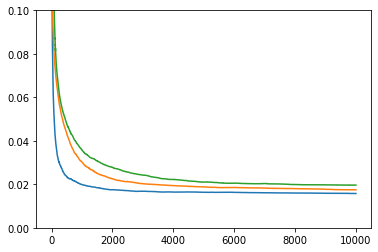

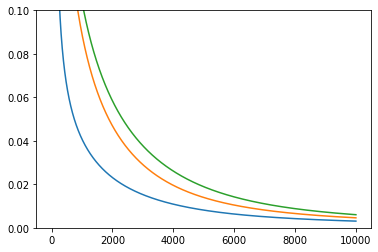

In [37]:
# plot
s, f = compatible['s'], compatible['f']
with open(data_dir + '/models/results/initialize_mnist/full_data/clf_s=%0.2f_f=%0.2f_GD_torch.pickle' % (s, f), 'rb') as handle:
    test = pickle.load(handle)
    
h, lr = 2000, 0.1
fig = plt.figure()
plt.ylim(0, 0.1)
plt.plot(1 - results['V1']['test_accuracy'][h][lr]['mean'])
plt.plot(1 - results['classical']['test_accuracy'][h][lr]['mean'])
plt.plot(1 - results['incompatible']['test_accuracy'][h][lr]['mean'])

fig = plt.figure()
plt.ylim(0, 0.1)
plt.plot(results['V1']['train_loss'][h][lr]['mean'])
plt.plot(results['classical']['train_loss'][h][lr]['mean'])
plt.plot(results['incompatible']['train_loss'][h][lr]['mean'])

In [18]:
2* 2

4